## Анализ и машинное обучение на основе Electronics Retail Company Dataset  

#### Анализ будет производится по скидкам, имеющимся за каждый заказ. При этом известно, что модель скидок зависит от количества на продажу за заказ и ее вид следующий:
```
DISCOUNT_RANGE = {
            range(1, 10): 0.0,
            range(10, 50): 0.1,
            range(50, 100): 0.2,
            range(100, 201): 0.25
}
```
#### Машинное обучение будет производится по факту изменения текущих скидок с учетом возможного увеличения/уменьшения продаваемого количества на заказ и возможного увеличения/уменьшения скидочных групп.

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
import seaborn as sns

Загружаем файл *electronics_retail_dataset.csv*, просматривая его первые строки

In [2]:
elec_retail = pd.read_csv(r"D:\\Dataset\electronics_retail_dataset.csv", parse_dates=["DateRequest"])
elec_retail.head()

,OrderID,Product,ProductCategory,Brand,Description,StandardCost,UnitPrice,DateRequest,QuantitySold,DiscountPrice,TotalPrice,CustomerName,CustomerRegion,CustomerCity,Canceled,Feedback
0,4839,URTP0LZJJ,Резистор,Unknown,точный сверхмощный 991 672 простой удобный над...,19.33,37.21,2024-04-01 09:19:58,31,0.10,1268.86,Наумов Панкрат Константиновна,Витебская область,Орша,0,NaN
1,4840,SJ49ITN7S,Разъем,Nexus Labs,NaN,16.70,27.94,2024-04-01 09:47:51,47,0.10,1444.50,Титова Алексей Алексеевна,Могилёвская область,Осиповичи,0,4.0
2,4841,UZFK8UT0C,Дисплей,Digit Solutions,NaN,21.08,41.52,2024-04-01 09:51:38,155,0.25,8044.50,Шаров Болеслав Романовна,Брестская область,Брест,0,4.0
3,4842,TOGN1W1HT,Индуктивность,Digit Solutions,надёжный простой новый быстрый 977 удобный 338...,21.38,39.44,2024-04-01 10:34:54,141,0.25,6951.30,Мельникова Владлен Даниилович,Могилёвская область,Бобруйск,0,5.0
4,4843,5LXO6QJIU,Транзистор,Nexus Labs,662 177 легкий точный новый удобный простой бы...,13.17,22.76,2024-04-01 10:43:05,87,0.20,2376.14,Колесникова Аверкий Игнатьевич,Гомельская область,Жлобин,0,4.0


Выводим краткую информацию по загруженному файлу. Можно заметить, что столбцы *Description* и *Feedback* имеют нулевые значения, но мы их не трогаем, так как в целом для анализа по скидкам эти строки нужны

In [3]:
elec_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderID          5000 non-null   int64         
 1   Product          5000 non-null   object        
 2   ProductCategory  5000 non-null   object        
 3   Brand            5000 non-null   object        
 4   Description      3015 non-null   object        
 5   StandardCost     5000 non-null   float64       
 6   UnitPrice        5000 non-null   float64       
 7   DateRequest      5000 non-null   datetime64[ns]
 8   QuantitySold     5000 non-null   int64         
 9   DiscountPrice    5000 non-null   float64       
 10  TotalPrice       5000 non-null   float64       
 11  CustomerName     5000 non-null   object        
 12  CustomerRegion   5000 non-null   object        
 13  CustomerCity     5000 non-null   object        
 14  Canceled         5000 non-null   int64  

Определяем числовые данные и выводим по ним статистику, при этом столбец *DiscountPrice* добавляется отдельно, так как он является зависимой переменной для нашего анализа

In [4]:
numeric_features = ['StandardCost', 'UnitPrice', 'QuantitySold', 'TotalPrice']
elec_retail[numeric_features + ['DiscountPrice']].describe()

,StandardCost,UnitPrice,QuantitySold,TotalPrice,DiscountPrice
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,11.859150,20.862206,101.90880,2345.230956,0.196700
std,7.428357,13.221302,58.52895,2455.745076,0.071771
min,0.220000,0.350000,1.00000,0.000000,0.000000
25%,5.500000,9.380000,50.00000,406.787500,0.200000
50%,10.920000,19.230000,103.00000,1499.300000,0.250000
75%,17.000000,29.770000,153.00000,3576.535000,0.250000
max,32.620000,59.270000,200.00000,14743.410000,0.250000


Строим гистограмму и диаграмму размаха для зависимой переменной, по частоте видно, что чаще производились заказы с повышенной скидкой в 25%, что также значит, что большинство заказов приходится на покупки с большим количеством. Диаграмма размаха даже показывает, что скидки в 0% и 10% являются "отщепенцами", тем не менее эти скидки для нас важны

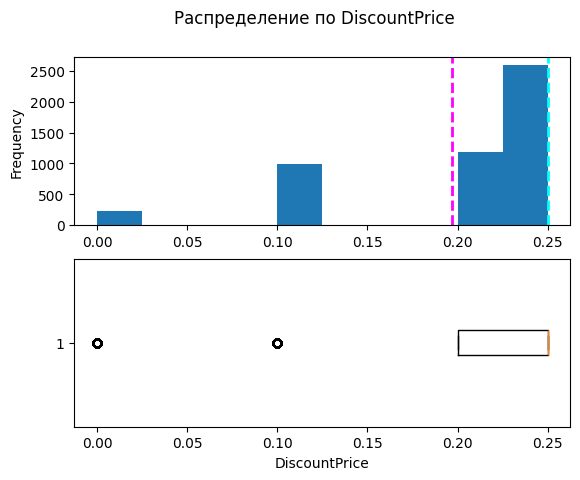

In [5]:
# Получаем столбец зависимой пременной
label = elec_retail['DiscountPrice']

# Создаем рисунок для 2 графиков (2 строки, 1 столбец)
fig, ax = plt.subplots(2, 1)

# Рисуем гистограмму
ax[0].hist(label, bins=10)
ax[0].set_ylabel('Frequency')

# Добавим линии для среднего значения, медианы
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Рисуем диаграмму размаха  
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('DiscountPrice')

# Добавим заголовок к рисунку
fig.suptitle('Распределение по DiscountPrice')

# Показываем графики
plt.show()

Строим гистограммы по числовым независимым переменным (рассматриваем в первую очередь их, так как категориальные переменные, такие как *Product* или *CustomerName*, в принципе, не оказывают влияния на *DisountPrice* из-за его жестко заранее определенности).  

Построив наши гистограммы, видим, что по столбцу *TottalPrice* данные смещены в лево, что говорит о частоте заказов на малые суммы. Остальные гистограммы не столь интересны, так как распределение равномерное

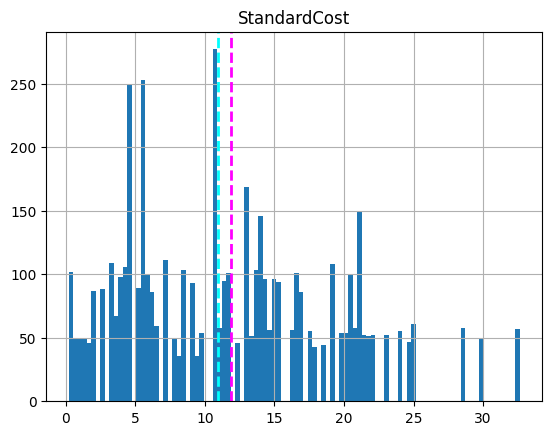

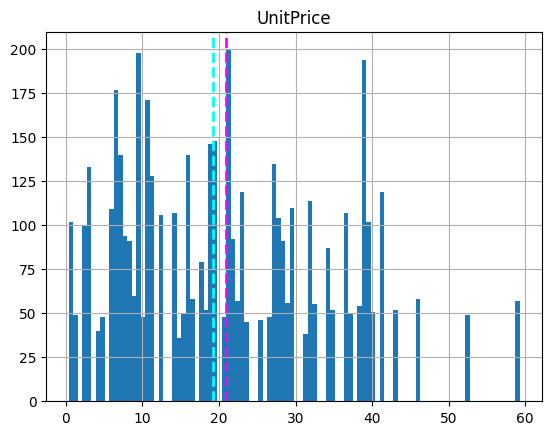

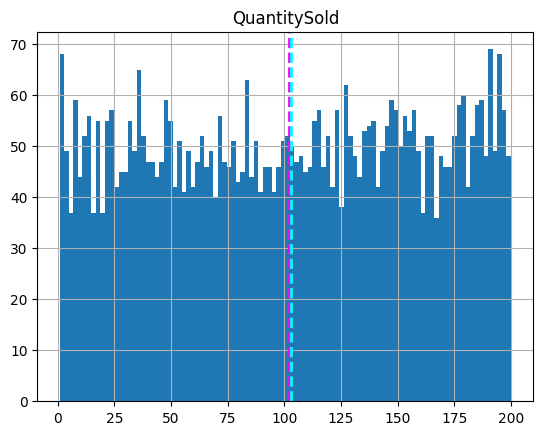

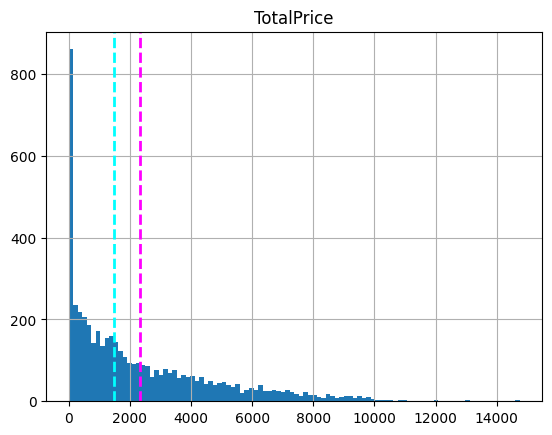

In [6]:
# Построим гистограммы для каждого числового объекта
for col in numeric_features:
    fig = plt.figure()
    ax = fig.gca()
    feature = elec_retail[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

Теперь мы можем взглянуть на отношения между числовыми характеристиками и наблюдаемой меткой *DiscountPrice*, строя диаграммы рассеяния. Заодно можем расчитать корреляцию, чтобы определить силу видимых отношений. Так как значения скидок жестко ограничены, рассеяния происходят по этим значениям скидок.  
Проанализировав графики, можно подметить, что *StandardCost* и *UnitPrice* не оказывают сущетсвенного влияния, а вот *QuantitySold* и *TotalPrice* идут по определенной зависимости. При этом, так как *DiscountPrice* изначально зависит от *QuantitySold*, корреляция между ними максимально положительна

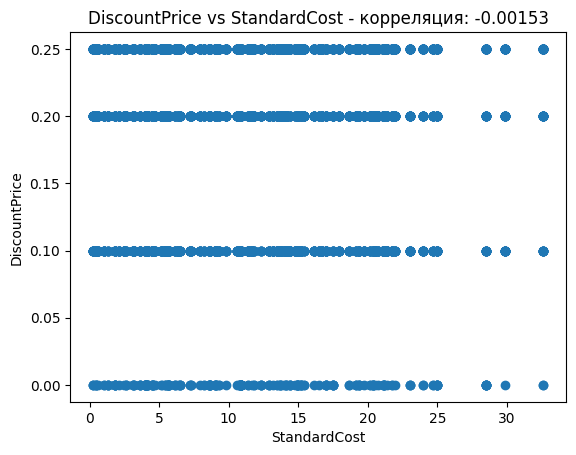

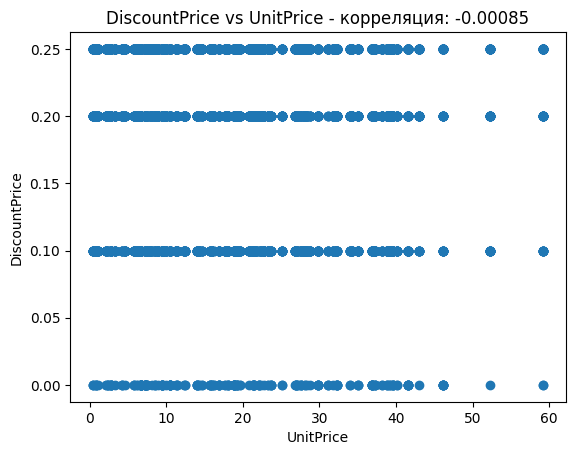

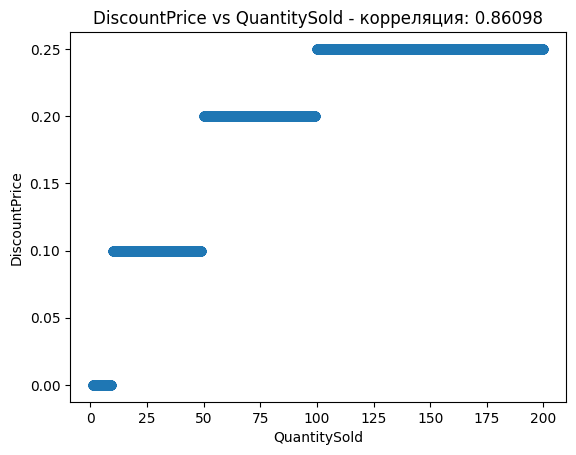

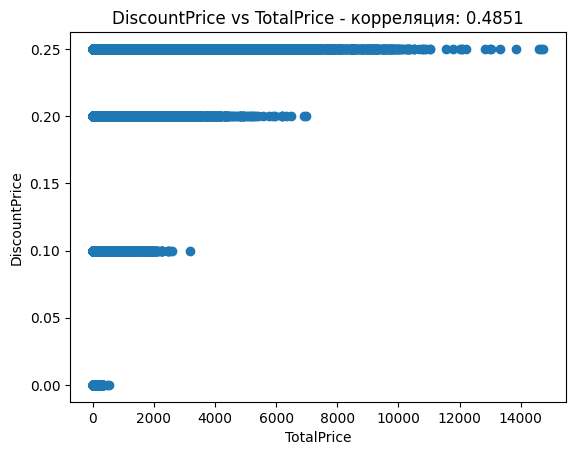

In [7]:
# Строим диаграммы рассеяния между числовыми характеристиками и отслеживаемой переменной
for col in numeric_features:
    fig = plt.figure()
    ax = fig.gca()
    feature = elec_retail[col]
    correlation = feature.corr(label) # label хранит отслеживаемую переменную
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('DiscountPrice')
    ax.set_title('DiscountPrice vs ' + col + ' - корреляция: ' + str(round(correlation, 5)))
plt.show()

Можем также сравнить категориальные данные по метке *DiscountPrice*. Но, так как скидки заранее жестко определены, диаграммы размаха не покажут определенно важного распределения между категориями.  

По итогу, анализ по скидкам показал явную зависимость между *DiscountPrice* и *QuantitySold* (что логично, учитывая то, как эти скидки формируются). Построим линию этой зависимости. По диаграмме рассеяния (построенной ранее между *DiscountPrice* и *QuantitySold*) видно, что зависимость нелинейна и скорее напоминает экспоненту. Поэтому построим модель, описывающую эту самую экспоненту. Также для целей прогнозирования можем настраивать диапазон количеств на продажу (необязательно как в датасете)

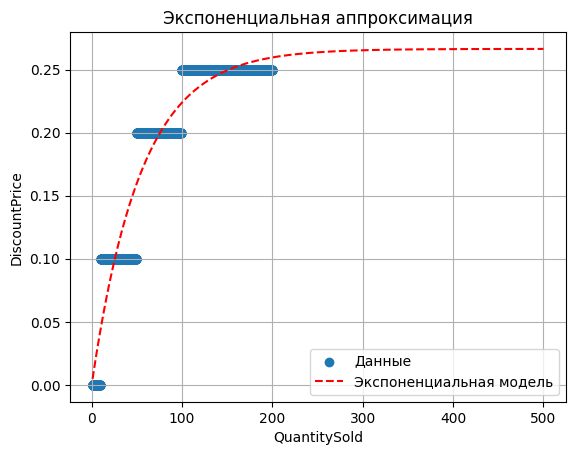

In [8]:
# Создаем необходимый диапазон количеств на продажу
quantity_range = 1, 500, 500 # Начало, конец и количество внутри диапазона

# Присваиваем необходимые данные переменным
x = elec_retail['QuantitySold']
y = elec_retail['DiscountPrice']

# Используемая экспоненциальная модель
def model(x, a, b):
    return a * (1 - np.exp(-b * x))

# Подгоняем модель с помощью curve_fit от scipy
params, _ = curve_fit(model, x, y, bounds=(0, 1.0))
a, b = params

# Предсказываем значения на основе модели
x_pred = np.linspace(*quantity_range)
y_pred = model(x_pred, a, b)

# Визуализируем
plt.scatter(x, y, label='Данные')
plt.plot(x_pred, y_pred, 'r--', label='Экспоненциальная модель')
plt.xlabel("QuantitySold")
plt.ylabel("DiscountPrice")
plt.legend()
plt.title("Экспоненциальная аппроксимация")
plt.grid(True)
plt.show()


Построив нашу модель по экспоненциальной зависимости, можем теперь подогнать ее под новые необходимые нам скидки. Для этого воспользуемся методами кластеризации, устанавливая заранее необходимое количество кластеров (групп)

In [9]:
# Устанавливаем количество групп скидок
groups = 5

# Подготавливаем данные, создавая датафрейм из получившихся значений в экспоненте
X = pd.DataFrame({'X': x_pred, 'Y': y_pred})

# Кластеризация
# Подход с логорифмированием переменной x и алгоритмом KMeans
X['LogX'] = np.log1p(X['X'])  # log(1 + X), чтобы избежать log(0)
kmeans = KMeans(n_clusters=groups, random_state=42)
X['Cluster'] = kmeans.fit_predict(X[['LogX']])

# Используем KMeans, но используем в качестве зависимой переменную y
"""
#kmeans = KMeans(n_clusters=groups, random_state=42)
#X['Cluster'] = kmeans.fit_predict(X[['Y']])
"""

# Еще подход с использованием алгоритма DBSCAN
"""
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=5, min_samples=groups).fit(X[['X', 'Y']])
X['Cluster'] = clustering.labels_
"""

# Делаем сводку из кластеров
cluster_summary = X.groupby('Cluster').agg({
    'X': ['min', 'max', 'mean'],
    'Y': 'mean'
}).round(2)

cluster_summary


X                   Y
           min    max   mean  mean
Cluster                           
0         67.0  157.0  112.0  0.23
1         19.0   66.0   42.5  0.14
2          1.0   18.0    9.5  0.04
3        299.0  500.0  399.5  0.27
4        158.0  298.0  228.0  0.26

Подход с алгоритмом KMeans и предварительным логарифмированием данных для предсказания устроил нас больше всего, так как данные сжимаются, а соответственно и кластеры, по длине самой экспоненты на этапе резкого ее подъема и при выравнивании линии расширяются. Подход при использовании, наоборот, зависимой переменной для предсказания распределяет кластеры по длине оси *у*, что не совсем предпочтительно из-за равномерности распределения самих скидок, а алгоритм DBSCAN распределяет данные по длине уже самой экспоненты и может пойти одноименный кластер с одними и теми же результатами.  

Определившись с нужным подходом, построим график - как визуально делятся наши кластеры

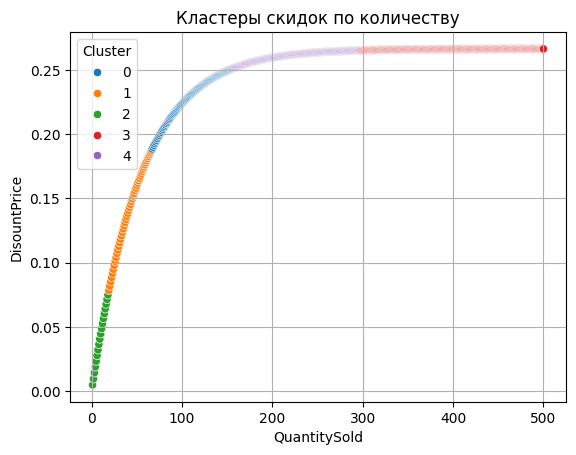

In [10]:
# Используем для удобства визуализации seaborn
sns.scatterplot(data=X, x='X', y='Y', hue='Cluster', palette='tab10')
plt.title("Кластеры скидок по количеству")
ax = plt.gca()
ax.set_ylabel('DisountPrice')
ax.set_xlabel('QuantitySold')
plt.grid(True)
plt.show()

Сохраним полученный результат в словарь (данные о скидках первоначально и хранились в нем)

In [11]:
# Предварительно создаем функцию для нашего округления
def custom_round(num):
    if num == 1:
        return 1  # Если 1, оставляем 1
    return round(num, -1)

# Получаем границы кластеров по QuantitySold
ranges = []
for cluster in sorted(X['Cluster'].unique()):
    subset = X[X['Cluster'] == cluster]
    min_q, max_q = int(subset['X'].min()), int(subset['X'].max())
    avg_d = round(subset['Y'].mean(), 4)
    ranges.append((range(custom_round(min_q), custom_round(max_q)), float(avg_d)))

# Формируем DISCOUNT_RANGE
new_discount_range = {r: d for r, d in ranges}
new_discount_range

{range(70, 160): 0.2281,
 range(20, 70): 0.1403,
 range(1, 20): 0.0416,
 range(300, 500): 0.2661,
 range(160, 300): 0.2611}

Можем вывести также результат анализа и прогнозирования скидок

In [12]:
# Сортируем по начальному значению диапазона
sorted_discounts = sorted(new_discount_range.items(), key=lambda x: x[0].start)

# Выводим в удобном нам формате
print("Количество продаж и соответствующие скидки:")
for sales_range, discount in sorted_discounts:
    print(f"{sales_range.start}-{sales_range.stop}: {discount:.2%}")

Количество продаж и соответствующие скидки:
1-20: 4.16%
20-70: 14.03%
70-160: 22.81%
160-300: 26.11%
300-500: 26.61%
